# Optimización de performance y costos – Proyecto Huella Hídrica

En este notebook analizamos cómo las decisiones de diseño del proyecto **Huella Hídrica en América Latina** impactan en:

- Costos de **almacenamiento** (S3).
- Costos de **cómputo** (EC2 + Spark + API).
- Uso del **Free Tier** de AWS.
- Equilibrio entre rendimiento, escalabilidad y costos.

Nos enfocamos en:
- Formatos (Parquet + compresión Snappy versus alternativas como CSV sin compresión).
- Particionamiento (por `country` / `year`/ `month` donde aplica).
- Encender y apagar las instancias EC2 de **API** y **Spark** desde Airflow.
- Políticas de ciclo de vida / retención de datos.
- Simulación de costos de API en un escenario futuro de pago.

El objetivo es mostrar, con números y gráficos, **qué ahorros logramos** y **qué trade-offs aceptamos**.


In [15]:
# Variables de entorno
import os
from google.colab import userdata

#Cargar las llaves de acceso AWS a colab
os.environ["AWS_ACCESS_KEY_ID"]     = userdata.get("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = userdata.get("AWS_SECRET_ACCESS_KEY")
os.environ["AWS_DEFAULT_REGION"]    = userdata.get("AWS_DEFAULT_REGION")

print("Credenciales cargadas desde Colab Secrets")
print("Región:", os.getenv("AWS_DEFAULT_REGION"))

Credenciales cargadas desde Colab Secrets
Región: us-east-2


In [16]:
!pip install boto3 pandas matplotlib -q

import math
import boto3
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# Crear sesión
session = boto3.Session(region_name=os.getenv("AWS_DEFAULT_REGION"))
s3_client = session.client("s3")

print("Región usada por boto3:", session.region_name)

Región usada por boto3: us-east-2


In [17]:
#Listar buckets
buckets = s3_client.list_buckets()
print("Buckets disponibles:")
for b in buckets["Buckets"]:
    print("-", b["Name"])

Buckets disponibles:
- aws-glue-assets-635615106505-us-east-2
- f1-scenary-results
- henry-pf-g2-huella-hidrica
- henry-pf-g2-huella-hidrica-dev
- henry-pf-g2-huella-hidrica-dev-ale
- weatherlytics-datalake-dev-us-east-2


In [18]:
# Nombre del bucket del data lake
BUCKET_NAME = "henry-pf-g2-huella-hidrica"

def get_prefix_size_bytes(bucket: str, prefix: str) -> int:
    """
    Suma el tamaño en bytes de todos los objetos bajo un prefijo en S3.
    """
    paginator = s3_client.get_paginator("list_objects_v2")
    total_size = 0

    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        contents = page.get("Contents", [])
        for obj in contents:
            total_size += obj["Size"]
    return total_size

def format_bytes(num_bytes: int) -> str:
    """
    Convierte bytes en cadena legible (KB, MB, GB, TB, ...).
    """
    if num_bytes == 0:
        return "0 B"
    units = ["B", "KB", "MB", "GB", "TB", "PB"]
    idx = int(math.floor(math.log(num_bytes, 1024)))
    power = math.pow(1024, idx)
    size = round(num_bytes / power, 2)
    return f"{size} {units[idx]}"


In [19]:
# Prefijos principales de cada capa
PREFIXES_CAPAS = {
    "bronze": "bronze/",
    "silver": "silver/",
    "gold":   "gold/",
}

rows_capas = []
for capa, prefix in PREFIXES_CAPAS.items():
    size_bytes = get_prefix_size_bytes(BUCKET_NAME, prefix)
    rows_capas.append({
        "Capa": capa,
        "Prefix": prefix,
        "Size_bytes": size_bytes,
        "Size_gb": size_bytes / (1024**3),
        "Size_legible": format_bytes(size_bytes),
    })

df_capas = pd.DataFrame(rows_capas)
df_capas


,Capa,Prefix,Size_bytes,Size_gb,Size_legible
0,bronze,bronze/,30867858,0.028748,29.44 MB
1,silver,silver/,13500976,0.012574,12.88 MB
2,gold,gold/,33560,0.000031,32.77 KB


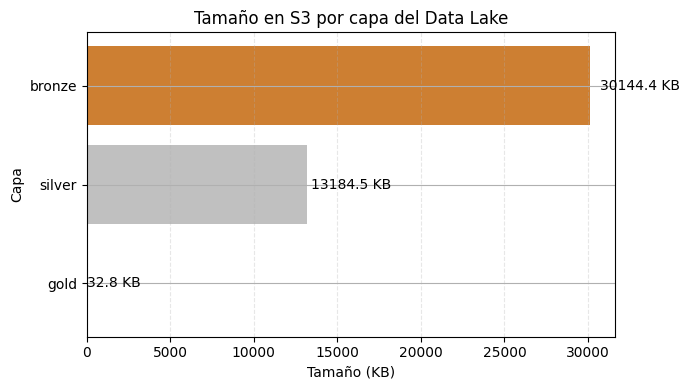

In [20]:
#Grafico tamaño por capa del data lake
# Conversión del tamaño de GB a KB
df_capas["Size_kb"] = df_capas["Size_gb"] * 1024 * 1024  # 1 GB = 1024^2 KB

plot_capas = df_capas.sort_values("Size_kb")

fig, ax = plt.subplots(figsize=(7, 4))
color_map = {
    "bronze": "#CD7F32",  # bronze
    "silver": "#C0C0C0",  # silver
    "gold":   "#FFD700"   # gold
}
colors = plot_capas["Capa"].map(color_map).tolist()

# Gráfico de barras
ax.barh(plot_capas["Capa"], plot_capas["Size_kb"], color=colors)

ax.set_xlabel("Tamaño (KB)")
ax.set_ylabel("Capa")
ax.set_title("Tamaño en S3 por capa del Data Lake")

# Etiquetas
for i, (capa, valor) in enumerate(zip(plot_capas["Capa"], plot_capas["Size_kb"])):
    ax.text(valor * 1.02 if valor > 0 else 0.1,
            i,
            f"{valor:.1f} KB",
            va="center")

ax.grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()



### Tamaño por capa del Data Lake

A partir de la medición en S3 vemos que:

- La capa **bronze** ocupa aproximadamente 0.03 GB (~30 MB).
- La capa **silver** ocupa alrededor de 0.013 GB (~13 MB).
- La capa **gold** es muy pequeña, del orden de algunos KB.

Todas las capas usan el mismo formato físico (**Parquet con compresión Snappy**),
pero:

- Bronze conserva datos más crudos y con más columnas.
- Silver contiene datos limpios y estandarizados.
- Gold solo guarda KPIs agregados.

Este patrón Bronze - Silver - Gold reduce el volumen que Spark necesita leer
en la capa analítica, lo que impacta directamente en **tiempos de ejecución y costos**.


In [21]:
PREFIXES_DETALLE = {
    # ---------- BRONZE ----------
    "bronze_jmp":         "bronze/jmp/",
    "bronze_open_meteo":  "bronze/open_meteo/",
    "bronze_world_bank":  "bronze/world_bank/",

    # ---------- SILVER (clean) ----------
    "silver_climate_monthly": "silver/climate_monthly/",
    "silver_jmp":             "silver/jmp/",
    "silver_socioeconomic":   "silver/socioeconomic/",

    # ---------- SILVER (model dimensional) ----------
    "silver_model_climate_annual":   "silver/model/climate_annual/",
    "silver_model_climate_monthly":  "silver/model/climate_monthly/",
    "silver_model_country":          "silver/model/country/",
    "silver_model_date":             "silver/model/date/",
    "silver_model_indicator":        "silver/model/indicator/",
    "silver_model_province":         "silver/model/province/",
    "silver_model_residence_type":   "silver/model/residence_type/",
    "silver_model_service_level":    "silver/model/service_level/",
    "silver_model_service_type":     "silver/model/service_type/",
    "silver_model_socioeconomic":    "silver/model/socioeconomic/",
    "silver_model_wash_coverage":    "silver/model/wash_coverage/",

    # ---------- GOLD (KPIs) ----------
    "gold_kpi01_climate_water":         "gold/model/kpi01_climate_water/",
    "gold_kpi02_water_mobility":        "gold/model/kpi02_water_mobility/",
    "gold_kpi03_critical_zones":        "gold/model/kpi03_critical_zones/",
    "gold_kpi04_health_risk_index":     "gold/model/kpi04_weighted_health_risk_index/",
    "gold_kpi05_urban_rural_gap_water": "gold/model/kpi05_urban_rural_gap_water/",
    "gold_kpi06_water_gdp_corr":        "gold/model/kpi06_water_gdp_corr/",
    "gold_kpi07_water_sanitation_gap":  "gold/model/kpi07_water_sanitation_gap/",
}


In [22]:
rows_detalle = []

for nombre, prefix in PREFIXES_DETALLE.items():
    size_bytes = get_prefix_size_bytes(BUCKET_NAME, prefix)

    # Detectar la capa
    capa = prefix.split("/")[0]  # bronze, silver o gold

    rows_detalle.append({
        "Capa": capa,
        "Grupo": nombre,
        "Prefix": prefix,
        "Size_bytes": size_bytes,
        "Size_gb": size_bytes / (1024**3),
        "Size_legible": format_bytes(size_bytes),
    })

df_detalle = pd.DataFrame(rows_detalle)

# Orden de capas: bronze -> silver -> gold
from pandas.api.types import CategoricalDtype
orden_capas = CategoricalDtype(["bronze", "silver", "gold"], ordered=True)
df_detalle["Capa"] = df_detalle["Capa"].astype(orden_capas)

# Ordenar por capa
df_detalle.sort_values(["Capa", "Size_gb"], ascending=[True, False], inplace=True)
df_detalle.reset_index(drop=True, inplace=True)
df_detalle





,Capa,Grupo,Prefix,Size_bytes,Size_gb,Size_legible
0,bronze,bronze_open_meteo,bronze/open_meteo/,28768819,2.679305e-02,27.44 MB
1,bronze,bronze_jmp,bronze/jmp/,1932138,1.799444e-03,1.84 MB
2,bronze,bronze_world_bank,bronze/world_bank/,166901,1.554387e-04,162.99 KB
3,silver,silver_model_climate_monthly,silver/model/climate_monthly/,11310394,1.053363e-02,10.79 MB
4,silver,silver_jmp,silver/jmp/,764357,7.118629e-04,746.44 KB
5,silver,silver_model_wash_coverage,silver/model/wash_coverage/,663139,6.175963e-04,647.6 KB
6,silver,silver_climate_monthly,silver/climate_monthly/,613738,5.715881e-04,599.35 KB
7,silver,silver_model_climate_annual,silver/model/climate_annual/,50235,4.678499e-05,49.06 KB
8,silver,silver_socioeconomic,silver/socioeconomic/,36613,3.409851e-05,35.75 KB
9,silver,silver_model_socioeconomic,silver/model/socioeconomic/,28644,2.667680e-05,27.97 KB


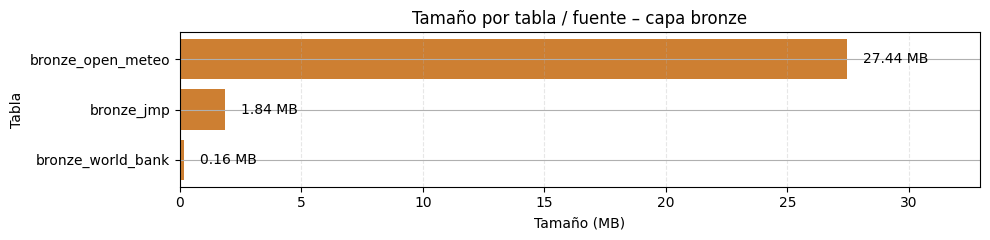

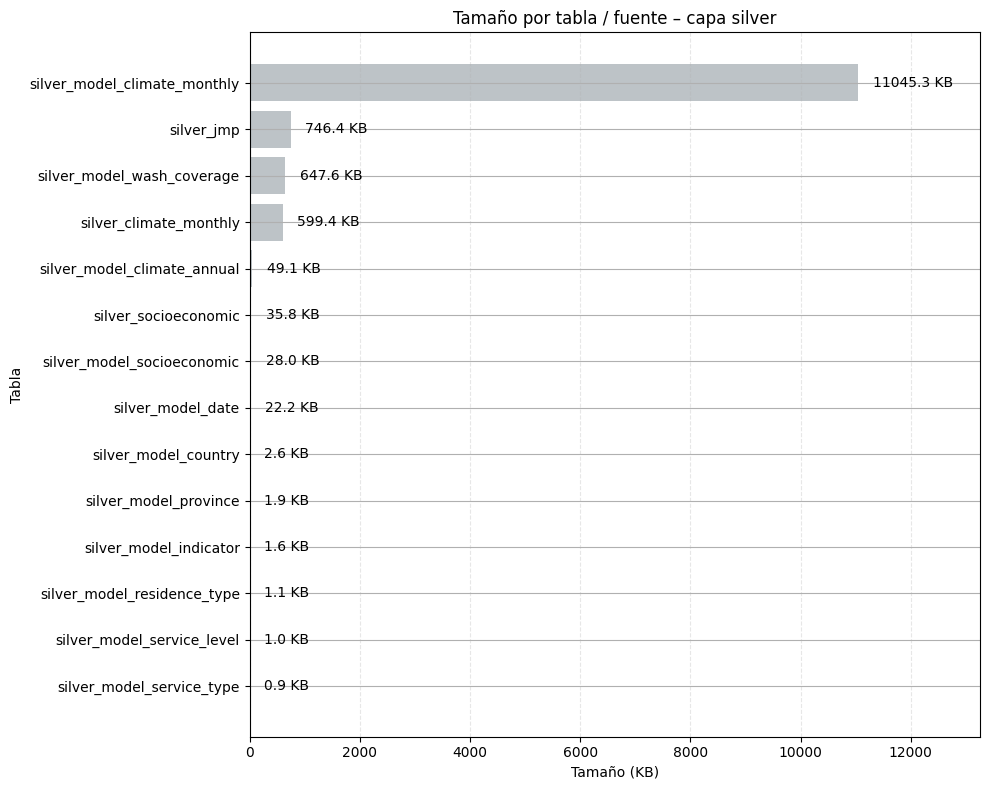

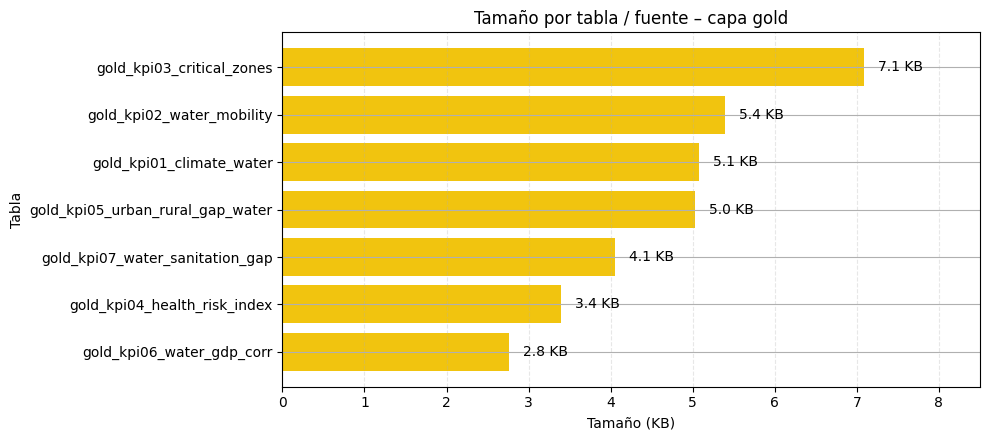

In [23]:
#Grafico de tamaño por tabla y fuente
# Aseguramos columnas en MB y KB
df_detalle["Size_mb"] = df_detalle["Size_gb"] * 1024
df_detalle["Size_kb"] = df_detalle["Size_bytes"] / 1024

for capa in ["bronze", "silver", "gold"]:
    sub = df_detalle[df_detalle["Capa"] == capa].copy()
    if sub.empty:
        continue

    # Unidad según la capa:
    if capa == "bronze":
        metric_col = "Size_mb"
        unit = "MB"
        decimals = 2
        color = "#CD7F32"   # color bronze
    elif capa == "silver":
        metric_col = "Size_kb"
        unit = "KB"
        decimals = 1
        color = "#BDC3C7"   # gris plateado
    else:  # gold
        metric_col = "Size_kb"
        unit = "KB"
        decimals = 1
        color = "#F1C40F"   # dorado

    # Ordenar de menor a mayor
    sub = sub.sort_values(metric_col, ascending=True)

    vmax = sub[metric_col].max()
    vmax = vmax * 1.2 if vmax > 0 else 1

    plt.figure(figsize=(10, 0.5 * len(sub) + 1))
    ax = plt.gca()

    ax.barh(sub["Grupo"], sub[metric_col], color=color)
    ax.set_xlabel(f"Tamaño ({unit})")
    ax.set_ylabel("Tabla")
    ax.set_title(f"Tamaño por tabla / fuente – capa {capa}")

    # Etiquetas
    for i, v in enumerate(sub[metric_col]):
        ax.text(v + vmax * 0.02, i, f"{v:.{decimals}f} {unit}", va="center")

    ax.set_xlim(0, vmax)
    ax.grid(axis="x", linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()






En estos gráficos se observa que:

- En **bronze**, la mayor parte del peso proviene de `bronze_open_meteo` (~27 MB), seguido de JMP y World Bank.
- En **silver**, la tabla `silver_model_climate_monthly` concentra la mayor parte del volumen, mientras que la mayoria de las dimensiones y hechos son muy livianas.
- En **gold**, todos los KPIs pesan solo unos cuantos KB, lo que hace que la capa analítica sea prácticamente gratuita en términos de almacenamiento.

Esto refuerza que el diseño Bronze - Silver - Gold y el uso de Parquet con compresión
mantienen el peso del data lake bajo control y optimizan los accesos de Spark.


### Almacenamiento S3
- Nota: Para las estimaciones utilizamos un precio de referencia de **0.023 USD/GB·mes**
- Para S3 Standard y **5 GB** de almacenamiento incluidos en el Free Tier. Estos valores son aproximados y pueden variar según la región, el tipo de cuenta y la fecha
- Se usan únicamente con fines educativos para dimensionar el orden de magnitud de los costos.


In [24]:
# Precio aproximado de S3 Standard (primeros 50 TB)
S3_STANDARD_PRICE_GB_MONTH = 0.023  # USD por GB·mes (aprox)
S3_FREE_TIER_GB = 5                 # 5 GB incluidos en el Free Tier

df_capas["costo_usd_mes"] = df_capas["Size_gb"] * S3_STANDARD_PRICE_GB_MONTH
df_capas

,Capa,Prefix,Size_bytes,Size_gb,Size_legible,Size_kb,costo_usd_mes
0,bronze,bronze/,30867858,0.028748,29.44 MB,30144.392578,6.612025e-04
1,silver,silver/,13500976,0.012574,12.88 MB,13184.546875,2.891966e-04
2,gold,gold/,33560,0.000031,32.77 KB,32.773438,7.188693e-07


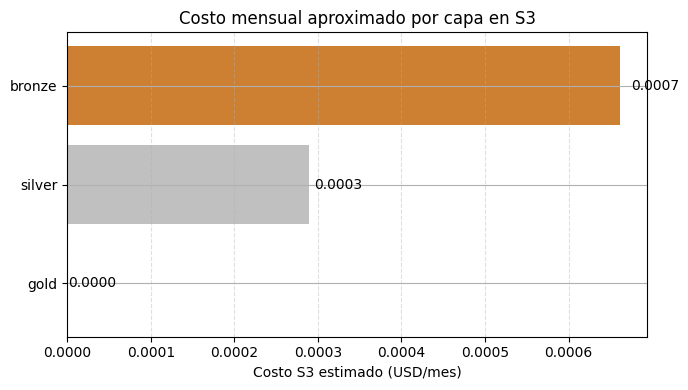

Costo total estimado de S3: 0.0010 USD/mes
Tamaño total del Data Lake: 0.0414 GB (Free Tier ~5 GB)


In [25]:
#Grafico costo mensual aproximado
# Ordenamos por costo
plot_capas = df_capas.sort_values("costo_usd_mes")

fig, ax = plt.subplots(figsize=(7, 4))

# Colores por capa:
color_map = {
    "bronze": "#CD7F32",  # bronze
    "silver": "#C0C0C0",  # silver
    "gold":   "#FFD700"   # gold
}
colors = plot_capas["Capa"].map(color_map).tolist()

# Gráfico de barras horizontal
ax.barh(plot_capas["Capa"], plot_capas["costo_usd_mes"], color=colors)

ax.set_xlabel("Costo S3 estimado (USD/mes)")
ax.set_ylabel("")
ax.set_title("Costo mensual aproximado por capa en S3")

# Etiquetas
for i, (capa, valor) in enumerate(zip(plot_capas["Capa"], plot_capas["costo_usd_mes"])):
    ax.text(valor * 1.02 if valor > 0 else 0.00001,
            i,
            f"{valor:.4f}",
            va="center")

ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# Totales
total_s3_cost = df_capas["costo_usd_mes"].sum()
total_size_gb = df_capas["Size_gb"].sum()
print(f"Costo total estimado de S3: {total_s3_cost:.4f} USD/mes")
print(f"Tamaño total del Data Lake: {total_size_gb:.4f} GB (Free Tier ~{S3_FREE_TIER_GB} GB)")




### Costos estimados de almacenamiento en S3

A partir de los tamaños medidos en S3:

- El **costo mensual estimado** del Data Lake es de aproximadamente **0.0010 USD/mes**.
- El **tamaño total** de las tres capas (Bronze, Silver y Gold) es de **0.0418 GB**, muy por debajo de los **5 GB** de referencia del Free Tier de S3.

Para estas estimaciones usamos un precio de referencia de **0.023 USD/GB·mes** para S3 Standard.
El objetivo no es calcular una factura exacta, sino mostrar el **orden de magnitud** del costo.

En la práctica, gracias al uso de **Parquet con compresión** y al hecho de que la capa Gold solo
contiene KPIs agregados, el almacenamiento de este proyecto es prácticamente
**costo cero** y no representa un cuello de botella de performance ni de presupuesto.


In [26]:
# Supuestos de precios on-demand aprox. (Linux, us-east-2)
# Fuente: página oficial de EC2 / calculadoras públicas (valores de referencia)
T3_SMALL_PRICE_HOUR       = 0.0208   # USD/hora (t3.small) API
C7I_FLEX_LARGE_PRICE_HOUR = 0.0848   # USD/hora (c7i-flex.large)  Airflow
M7I_LARGE_PRICE_HOUR      = 0.0958   # USD/hora (m7i.large) Spark

def ec2_monthly_cost(hours_per_day, price_per_hour, days=30):
    """Costo mensual aproximado para una instancia dada."""
    return hours_per_day * days * price_per_hour

# 3 instancias
instances = pd.DataFrame({
    "componente": ["API / FastAPI", "Spark",      "Airflow"],
    "tipo_instancia": ["t3.small",  "m7i.large",  "c7i-flex.large"],
    "precio_usd_hora": [
        T3_SMALL_PRICE_HOUR,        # API
        M7I_LARGE_PRICE_HOUR,       # Spark
        C7I_FLEX_LARGE_PRICE_HOUR,  # Airflow
    ],
    # Horas de uso por día en cada escenario
    "horas_A_24_7": [24, 24, 24],   # Escenario A: siempre encendidas
    "horas_B":      [1,  2,  24],   # Escenario B: API 1h/día, Spark 2h/día, Airflow 24h
})

# Cálculo de costos mensuales por escenario
instances["costo_A_usd_mes"] = instances.apply(
    lambda r: ec2_monthly_cost(r["horas_A_24_7"], r["precio_usd_hora"]), axis=1
)
instances["costo_B_usd_mes"] = instances.apply(
    lambda r: ec2_monthly_cost(r["horas_B"], r["precio_usd_hora"]), axis=1
)

instances


,componente,tipo_instancia,precio_usd_hora,horas_A_24_7,horas_B,costo_A_usd_mes,costo_B_usd_mes
0,API / FastAPI,t3.small,0.0208,24,1,14.976,0.624
1,Spark,m7i.large,0.0958,24,2,68.976,5.748
2,Airflow,c7i-flex.large,0.0848,24,24,61.056,61.056


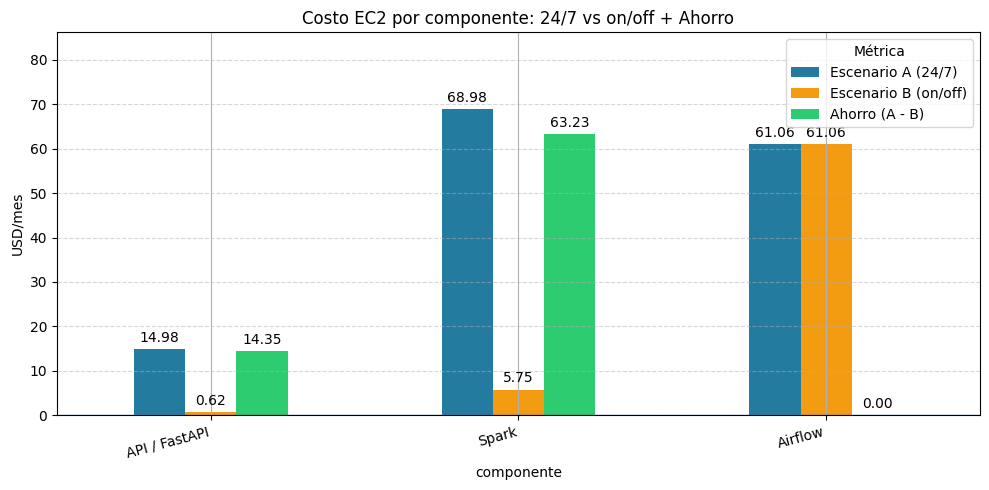

Costo total Escenario A (24/7):   145.01 USD/mes
Costo total Escenario B (on/off): 67.43 USD/mes
Ahorro absoluto:                  77.58 USD/mes
Ahorro relativo aproximado:       54%


In [27]:
# Grafico costo EC2 + Ahorro
plot_df = (
    instances
    .set_index("componente")[["costo_A_usd_mes", "costo_B_usd_mes"]]
    .rename(columns={
        "costo_A_usd_mes": "Escenario A (24/7)",
        "costo_B_usd_mes": "Escenario B (on/off)"
    })
)

# Ahorro absoluto por componente (USD/mes)
plot_df["Ahorro (A - B)"] = plot_df["Escenario A (24/7)"] - plot_df["Escenario B (on/off)"]

fig, ax = plt.subplots(figsize=(10, 5))

# A = azul, B = naranja, Ahorro = verde
colors = ["#247BA0", "#F39C12", "#2ECC71"]

plot_df.plot(kind="bar", ax=ax, color=colors)

ax.set_ylabel("USD/mes")
ax.set_title("Costo EC2 por componente: 24/7 vs on/off + Ahorro")
ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
ax.axhline(0, linewidth=1, alpha=0.7)

# Límites
max_val = plot_df.to_numpy().max()
min_val = plot_df.to_numpy().min()
if min_val < 0:
    ax.set_ylim(min_val * 1.25, max_val * 1.25)
else:
    ax.set_ylim(0, max_val * 1.25)

# Etiquetas
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

ax.legend(title="Métrica", loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# Cálculo de totales y ahorro
total_A = instances["costo_A_usd_mes"].sum()
total_B = instances["costo_B_usd_mes"].sum()
ahorro_usd = total_A - total_B
ahorro_rel = ahorro_usd / total_A if total_A else 0

print(f"Costo total Escenario A (24/7):   {total_A:.2f} USD/mes")
print(f"Costo total Escenario B (on/off): {total_B:.2f} USD/mes")
print(f"Ahorro absoluto:                  {ahorro_usd:.2f} USD/mes")
print(f"Ahorro relativo aproximado:       {ahorro_rel:.0%}")




### Costos de cómputo en EC2 y ahorro con Airflow

Modelamos dos escenarios para las tres instancias EC2 del proyecto:

- **API / FastAPI**: `t3.small`
- **Spark**: `m7i-flex.large`
- **Airflow**: `c7i-flex.large`

#### Escenario A – 24/7

En este escenario las tres instancias se mantienen encendidas 24 horas al día:

- API (`t3.small`): **14.98 USD/mes**
- Spark (`m7i-flex.large`): **68.98 USD/mes**
- Airflow (`c7i-flex.large`): **61.06 USD/mes**

El costo total estimado es de **145.01 USD/mes**.

#### Escenario B – Airflow enciende y apaga API y Spark

En este escenario:

- **Airflow** se mantiene encendida (24 h/día) para orquestar el pipeline.
- Airflow **enciende la API** solo durante la ventana de ingesta diaria (~1 h/día).
- Airflow **enciende Spark** solo durante la ejecución de los ETL (~2 h/día).
- Al terminar los DAGs, API y Spark se apagan automáticamente.

Con este patrón de uso:

- API (`t3.small`): **0.62 USD/mes**
- Spark (`m7i-flex.large`): **5.75 USD/mes**
- Airflow (`c7i-flex.large`): **61.06 USD/mes**

El costo total baja a **67.43 USD/mes**, lo que implica un **ahorro aproximado del 54 %** frente al escenario 24/7.

Este diseño funciona como un autoscaling, solo mantenemos encendidos los
recursos que están trabajando en cada momento. Así logramos una arquitectura de datos completa
(API + Spark + Airflow) con un costo de cómputo controlado.


## Ciclo de vida y retención de datos

Aunque el volumen actual de datos del proyecto es pequeño, el diseño del Data Lake está pensado
para crecer sin que los costos se disparen. Para ello definimos una estrategia de ciclo de vida
diferenciada por capa dentro de un único bucket S3 (`henry-pf-g2-huella-hidrica`), usando reglas
de lifecycle filtradas por **prefijo** (`bronze/`, `silver/`, `gold/`).

### Capa Bronze: datos crudos desde las APIs (`bronze/`)
- Guardar la **respuesta original** de las APIs (Open-Meteo, JMP, World Bank).
- Permitir reprocesar o depurar errores sin volver a llamar a la API.

**Regla real de ciclo de vida en S3**:

- Día 0–360: los objetos se almacenan en **S3 Standard**.
- Día 360–720: los datos se mueven automáticamente a **Standard-IA (Acceso poco frecuente)**.
- A partir del día 720: los objetos pasan a **Glacier Instant Retrieval**.

Con esto, los datos crudos recientes siguen siendo fáciles de consultar, mientras que los históricos
de varios años se guardan en clases de almacenamiento mucho más baratas. Si alguna vez necesitamos
reprocesar periodos muy antiguos, siguen disponibles en Glacier Instant Retrieval (con un pequeño
costo de recuperación), pero no ocupan espacio caro en Standard.

### Capa Silver – datos limpios y modelo dimensional (`silver/`)

- Contener las tablas **limpias y estandarizadas** por fuente (clima, WASH, socioeconómico).
- Mantener el **modelo dimensional** (dimensiones y hechos) sobre el que se construye Gold.

Para Silver definimos una política más conservadora:

- Actualmente mantenemos todos los datos en **S3 Standard**, sin reglas de transición automáticas.
- Conceptualmente, si el volumen creciera mucho, podríamos mover **años muy antiguos** a
  **Standard-IA**, conservando en Standard los últimos años que se consultan con mayor frecuencia.

En esta primera versión, por el bajo tamaño del Data Lake, priorizamos la simplicidad y dejamos
Silver íntegramente en Standard.

### Capa Gold – KPIs y vistas analíticas (`gold/`)
- Exponer los **KPIs listos para consumo** (KPI01–KPI07) que utiliza el dashboard.
- Contener solo los datos agregados estrictamente necesarios para el análisis.

En Gold el ciclo de vida es:

- Los KPIs se **recalculan semanalmente** a partir de Silver, sobrescribiendo la versión vigente.
- Gold se almacena en **S3 Standard**, ya que es la capa de acceso más frecuente (dashboard).
- No definimos de momento reglas de transición ni expiración, porque no acumulamos snapshots
  históricos: si hiciera falta reconstruir algo, podemos volver a generarlo desde Silver.

### Análisis:

- Usamos un **único bucket S3**, pero aplicamos el ciclo de vida por **prefijo** para cada capa.
- Bronze tiene una política concreta de transición (Standard → Standard-IA → Glacier IR) que maximiza
  el ahorro en datos crudos poco usados.
- Silver y Gold se mantienen en Standard en esta versión, con una estrategia conceptual preparada
  para mover históricos a almacenamiento más barato o regenerar resultados desde capas anteriores.

De esta forma, el Data Lake Bronze–Silver–Gold no solo organiza los datos por nivel de calidad,
sino que también tiene una estrategia clara de **retención y costos**.


## Trade-offs de diseño entre rendimiento, escalabilidad y costos

En esta sección detallamos las decisiones clave:

### 1. Parquet + compresión Snappy

- **A favor:** archivos mucho más pequeños y lecturas más rápidas; Spark lee solo las columnas necesarias, lo que hace que **los procesos tarden menos tiempo** y usen menos CPU.
- **En contra:** no son tan “amigables” de abrir como un CSV.
- **Trade-off:** el ahorro en tiempo de ejecución y en cómputo es mucho mayor que la incomodidad de no verlos directo en un editor de texto.

### 2. Particionamiento por país, año (y mes para clima)

- Aplicamos particionado tanto en **Bronze** (por ejemplo, clima crudo de Open-Meteo) como en las tablas de hechos y dimenciones dentro de la capa **Silver**:
  - Por **country** y **year** en la mayoría de los datasets.
  - Por **country / year / month** en los hechos y dimensiones relacionados con clima, donde el análisis es más granular.
- **A favor:** cuando calculamos un KPI para un país y un rango de años (o meses, en clima), Spark solo lee las particiones relevantes, en lugar de escanear todo el dataset.
- **En contra:** más carpetas en S3 y un poco más de complejidad al escribir los jobs.
- **Trade-off:** aceptamos esa complejidad extra porque el esquema de particiones refleja cómo realmente consultamos los datos (país, años y, en clima, meses).

### 3. Clases de almacenamiento y ciclo de vida

- **Bronze:** Standard → Standard-IA → Glacier Instant Retrieval a partir de cierto tiempo, para abaratar el almacenamiento de datos crudos que casi no se consultan.
- **Silver y Gold:** se quedan en Standard; Silver como base para recalcular y Gold como capa de acceso frecuente para el dashboard.
- **Trade-off:** aplicamos lifecycle solo donde hay más beneficio (Bronze) y mantenemos simples las capas que se usan todo el tiempo.

### 4. Tres instancias EC2 + encendido/apagado

- **Diseño:** API, Spark y Airflow en instancias separadas, dentro de la misma VPC.
- **A favor:** dimensionamos cada rol por separado y, con Airflow, encendemos solo lo necesario durante la ventana de proceso.
- **Resultado:** en la simulación, pasar de un uso 24/7 a un esquema on/off reduce el costo estimado de cómputo aproximadamente a la mitad.
- **Trade-off:** más orquestación y monitoreo, a cambio de no pagar por recursos ociosos.

### 5. Capa Bronze como caché de APIs

- **A favor:** guardamos el dato crudo una sola vez y luego podemos reprocesar históricos sin depender de la API.
- **En contra:** ocupamos algo más de espacio en S3 y añadimos una etapa extra en el pipeline.
- **Trade-off:** pagamos muy poco almacenamiento adicional a cambio de tener una arquitectura más robusta y fácil de mantener en el tiempo.
